In [1]:
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Optimizer
from torchvision import datasets, transforms

import copy
from torch.nn.utils import clip_grad_norm_
import time
import matplotlib.pyplot as plt

In [2]:
from math import sqrt
def get_norm(model):
    total_norm_sq = 0.0
    for p in model.parameters():
        if p.grad is not None:
            # p.grad.data.norm(2) returns a tensor, .item() gets the Python float
            param_norm = p.grad.data.norm(2).item()
            total_norm_sq += param_norm ** 2
    return sqrt(total_norm_sq)

In [3]:
def plot_two_metrics(metric1, metric2, label1='Loss', label2='Gradient Norm'):
    """
    Plot two lists on the same figure.

    Args:
        metric1 (list of float): First metric values.
        metric2 (list of float): Second metric values.
        label1 (str): Label for the first metric.
        label2 (str): Label for the second metric.
    """
    plt.figure()
    plt.plot(metric1, label=label1)
    plt.plot(metric2, label=label2)
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title('Metrics Over Iterations')
    plt.legend()
    plt.show()

# If you don't already have it, define get_norm(model):
def get_norm(model):
    total_norm_sq = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total_norm_sq += p.grad.data.norm(2).item() ** 2
    return total_norm_sq ** 0.5


In [4]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set  = datasets.CIFAR10(root='./data', train=False, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
                             ]))

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_set,  batch_size=256, shuffle=False, num_workers=4)


# Dataloading
subset_size  = int(0.002 * len(train_set))
rest_size    = len(train_set) - subset_size
small_train, _ = random_split(train_set, [subset_size, rest_size])

small_loader = DataLoader(
    small_train,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    persistent_workers=True)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(64 * 8 * 8, 128)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 -> 8x8
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [6]:
len(small_loader)

1

In [7]:
from VADAM import VADAM

In [8]:
#optim_params= dict(lr=0.1, momentum=0.9, weight_decay=5e-4)
#optimizer= optim.SGD(model.parameters(),**optim_params)

model= SimpleCNN().to(device)
optim_params= dict(beta1=0.9, beta2=0.999, eta= 0.001, beta3=10,eps=1e-8, weight_decay=5e-4, power=2, normgrad= False, lr_cutoff= 99)
optimizer= VADAM(model.parameters(), **optim_params)


2.309939384460449
total_sq_norm: 0.010057984589877833
2.2074241638183594
total_sq_norm: 0.011166730952709258
2.1713545322418213
total_sq_norm: 0.013396833592196344
2.1459710597991943
total_sq_norm: 0.016826784521981608
2.105344533920288
total_sq_norm: 0.018429769688736997
2.0784919261932373
total_sq_norm: 0.02277672610944137
2.023897171020508
total_sq_norm: 0.029719611236942
2.0021908283233643
total_sq_norm: 0.03877357217061217
1.958693265914917
total_sq_norm: 0.050612871200428344
1.9325230121612549
total_sq_norm: 0.05951650047063595
1.9032559394836426
total_sq_norm: 0.06449162848730339
1.8197503089904785
total_sq_norm: 0.07768817339820089
1.8112667798995972
total_sq_norm: 0.09034524147864431
1.7611663341522217
total_sq_norm: 0.10290157963390811
1.7280465364456177
total_sq_norm: 0.11662142348359339
1.751247525215149
total_sq_norm: 0.12326430937537225
1.732242465019226
total_sq_norm: 0.12523841009897296
1.6260792016983032
total_sq_norm: 0.14151088940707268
1.582932472229004
total_sq_nor

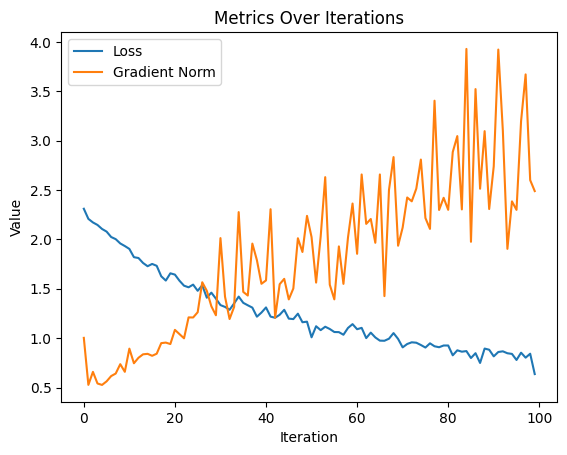

Final Loss: 0.6362926363945007


In [9]:
losses = []
norms  = []

for epoch in range(100):
    for inputs, targets in small_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        print(loss.item())
        # record metrics before the step
        losses.append(loss.item())
        norms.append(get_norm(model))
        optimizer.step()


plot_two_metrics(losses, norms, label1='Loss', label2='Gradient Norm')

print("Final Loss:", losses[-1])



In [10]:
model2= SimpleCNN().to(device)
optim_params= dict(lr= 0.005, weight_decay=5e-4)
optimizer2= optim.AdamW(model2.parameters(), **optim_params)



Final Loss (model2): 0.8598


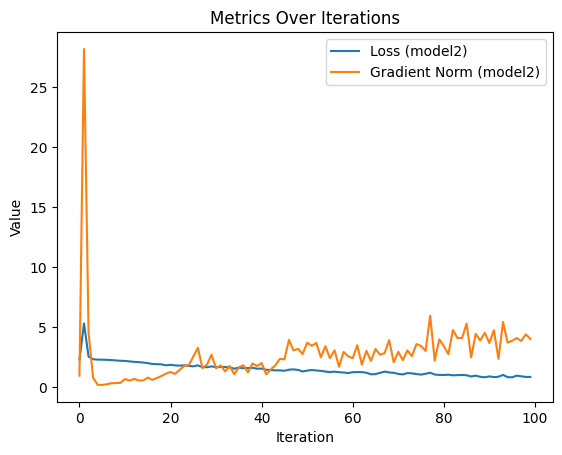

In [11]:
losses2 = []
norms2  = []

for epoch in range(100):
    for inputs, targets in small_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer2.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # record
        losses2.append(loss.item())
        norms2.append(get_norm(model2))
        
        optimizer2.step()

# print final loss
print(f"Final Loss (model2): {losses2[-1]:.4f}")

plot_two_metrics(losses2, norms2, label1='Loss (model2)', label2='Gradient Norm (model2)')
